# Analysis Pipeline - OASIS (Deconvolution)
<div align="right">Aharoni Lab</div><br>

**Requirements:**
  * [OASIS package](https://github.com/j-friedrich/OASIS)

**Setup:**
  * Download OASIS Python version from the link above. Follow the installation instruction.
  * Test whether the demo notebook, **Examples/Demo.ipynb** works as expected.
  * Put this notebook file within the OASIS directory.
  
**Overview:**

This Notebook runs through the deconvolution step of 1-p calcium fluorescence analysis using the OASIS package. It imports the raw fluorescence data generated from **"Analysis_Pipeline-CaImAn.ipynb"**, and runs a small batch of cell traces through deconvolution, optimizing some tuning variables. It then allows you to manually choose how closely you wish to replicate the raw trace of the cells. As the last step, you can run deconvolution with your own settings on all cells and save the results.

## 1. Import All Libraries
**pickle** for loading raw fluorescence data<br>
**matplotlib** for plotting<br>
**time** for calculating process time<br>
**random** for selecting test cells<br>
**math** for ...calculations<br>
**pandas** for ...making data look neat<br>
**numpy** for regression<br>
**oasis** package for deconvolution<br>

In [1]:
%matplotlib inline
import pickle
import matplotlib.pyplot as plt
import time
import random
import math
import pandas as pd
import numpy as np
from sys import path
path.append('../OASIS/')
from oasis.functions import gen_data, gen_sinusoidal_data, deconvolve, estimate_parameters
from oasis.plotting import simpleaxis
from oasis.oasis_methods import oasisAR1, oasisAR2

../OASIS\oasis\functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


`path.append('path/to/OASIS')` line here allows the user to place this Notebook wherever you want, as long as you specify where the notebook can find the OASIS directory.

## 2. Function Definitions

In [2]:
# Not actually using this. Leaving the section for future use.
def simpleaxis(ax):
    """plot only x and y axis, not a frame for subplot ax"""
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

## 3. Load Raw Fluorescence Data from CNMF-E

The imported data format must be a cell list of the raw fluorescence trace lists such that:<br>[ [cell_1 raw fluorescence trace by frame] [cell_2 raw fluorescence trace by frame] ... [cell_n raw fluorescence trace by frame] ]

This can be obtained from CaImAn part of the pipeline (**Analysis_Pipeline-CaImAn.jpynb**)

Loaded 609 cell fluorescence traces.


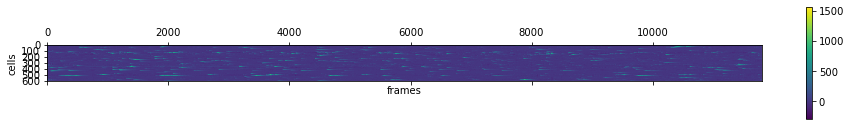

In [4]:
est = 'raw_fluorescence.obj'
r = 15 # frame rate is 15 fps

with open(est, 'rb') as file:
    raw = pickle.load(file)#[0]

print("Loaded", len(raw), "cell fluorescence traces.")
plt.matshow(raw)
plt.xlabel('frames')
plt.ylabel('cells')
plt.colorbar()
plt.show()

## 4. Extract Constraints for $g_1$ and $g_2$ before Manually Choosing Them

Other parameters pre-set here aside, (using AR2, L1, optimization, ...) $g_1$ and $g_2$ are the two variables that directly and significantly impact the deconvolution fit. They are related to decay times $\tau_d$ and $\tau_r$, although the actual meaning of these two decay times are unclear (it doesn't seem to be the time in seconds for the fluorescence to change by a factor e.)

Running optimization for the g values with all hundreds of cells is unrealistic due to a few reasons:
  * Optimization takes too long (a few minutes each for some cells)<br>
  * It fails for some cells (throws math value error, which happens with negative values in log or sqrt)<br>
  * Even when the optimization succeeds, the resulting neural activity is very ugly for a lot of the cells.<br>

Thus, we resort to manually looking for suitable $g_1$ and $g_2$ to apply to all cell deconvolutions. We know a few things about $g_0$ and $g_1$, such as:

$g=(g_1,g_2)$ is related to the decay time $\tau_d$ and rise time $\tau_r$ (in seconds) of the Ca response kernel $e^{-t/\tau_d}-e^{-t/\tau_r}$ as <br>
  1. $g_1=e^{-\frac{1}{\tau_d r}}+e^{-\frac{1}{\tau_r r}}$ and <br>
  2. $g_2=-e^{-\frac{1}{\tau_d r}}\cdot e^{-\frac{1}{\tau_r r}}$ with imaging rate r in Hz.
  3. In addition, after plotting $g_1$ vs. $g_2$ for a few dozen cells, I realized the two variables exhibit a **strong linear relationship.** Any combination of $g_1$ and $g_2$ outside of this line appears to fail, or produce an ugly neural activity fit. This allows us to extract one more constraint. I'm not sure why this is the case as of now.
  4. The deconvolution step includes calculating $\sqrt{g_1^2 + 4g_2}$. Thus the value inside has to be positive.
  5. There seems to be one more constraint in the deconvolution step...which I haven't dug deep enough in the algorithm to figured out yet.
  
From the above four, we can conclude the following, respectively:
  1. Since the $\tau$'s and $r$ are positive, $0<g_1<2$
  2. Since the $\tau$'s and $r$ are positive, $-1<g_2<0$
  3. $g_2 = mg_1 + b$
  4. $g_1^2 > -4g_2$
  
From these, we can try out $g_1$ and $g_2$ combinations that satisfy all four conditions. **Higher absolute values for $g_1$ (and thus smaller $g_2$) seem to generate sparser neural activities.** (Instinctively, as $\tau$'s increase, absolute values of $g$'s should increase, so this isn't a surprise. I can replace $g_1$ and $g_2$ with $\tau_r$ and $\tau_d$ to find out what's precisely going on in terms of the decay time constants, but when I solved for the $\tau$'s from the "pretty" deconvolution results and their g values, they didn't seem physically meaningful.)
  
We proceed by looking for the $m$ and $b$ from the condition 3.

### 4.(a) Let's grab a few dozen cells, find their optimized g values.

In [39]:
# Choose N different random cells in the list
sampleN = 25

cells=random.sample(range(0, len(raw)), sampleN)
c={}
s={}
b={}
g={}
lam={}
t={}
tau_d = {}
tau_r = {}

for i in cells:
    # We're using... AR(2): G(None, None), 
    #                L1 Norm: penalty=1, 
    #                50 initial points for decay const: optimize_g, 
    #                3 optimization steps each: max_iter=3
    t1 = time.process_time()
    c[i], s[i], b[i], g[i], lam[i] = deconvolve(raw[i], g=([1.9491997889191948, -0.9498434354897785]), penalty=1, optimize_g=50, max_iter=3) 
    t2 = time.process_time()
    t[i] = t2 - t1
    g1, g2 = g[i]
    tau_d[i] = 1 / (r * np.log((-g1 + math.sqrt(pow(g1, 2) + 4 * g2)) / (2 * g2)))
    tau_r[i] = -tau_d[i] / (r * tau_d[i] * np.log(-g2) + 1)

C:\Users\raymo\Documents\GitHub\OASIS\oasis\functions.py:167: UserWarning: Optimization of AR parameters is already fairly stable for AR(1), but slower and more experimental for AR(2)
  warn("Optimization of AR parameters is already fairly stable for AR(1), "


Wall time: 1min 25s
Wall time: 573 ms
Wall time: 1.19 s
Wall time: 3.8 s
Wall time: 163 ms
Wall time: 306 ms
Wall time: 4.38 s
Wall time: 1.76 s
Wall time: 347 ms
Wall time: 4.16 s
Wall time: 3.97 s
Wall time: 1.65 s
Wall time: 2.69 s
Wall time: 1.93 s
Wall time: 2.5 s
Wall time: 1.43 s
Wall time: 311 ms
Wall time: 3.05 s
Wall time: 2.35 s
Wall time: 3.39 s
Wall time: 278 ms
Wall time: 4.22 s
Wall time: 3.03 s
Wall time: 4.8 s
Wall time: 2.36 s
Wall time: 3.09 s
Wall time: 3.31 s
Wall time: 2.15 s
Wall time: 4.5 s
Wall time: 3.1 s


In [43]:
deconvolved_data = pd.DataFrame(cells, index=cells, columns=['cell'])
deconvolved_data['g']=deconvolved_data.cell.map(g)
deconvolved_data[['g1','g2']] = pd.DataFrame(deconvolved_data.g.values.tolist(), index=deconvolved_data.index)
deconvolved_data['tau_d']=deconvolved_data.cell.map(tau_d)
deconvolved_data['tau_r']=deconvolved_data.cell.map(tau_r)
deconvolved_data['time']=deconvolved_data.cell.map(t)
deconvolved_data['background']=deconvolved_data.cell.map(b)
deconvolved_data['Lagrangian']=deconvolved_data.cell.map(lam)
deconvolved_data['calcium']=deconvolved_data.cell.map(c)
deconvolved_data['spike']=deconvolved_data.cell.map(s)

deconvolved_data[['time', 'g1', 'g2', 'tau_d', 'tau_r', 'background', 'Lagrangian']]

time        g1        g2     tau_d     tau_r  background  \
257  292.468750  1.616464 -0.627423  2.110375  0.153418    0.660705   
276    2.312500  1.916169 -0.917924  1.608843  1.508207    0.093802   
239    4.750000  1.834649 -0.838319  2.489564  0.445700    0.609184   
88    15.125000  1.858076 -0.861931  1.787682  0.599047    0.000000   
525    0.687500  1.938228 -0.939178  2.269161  1.997768    0.000000   
542    1.187500  1.948101 -0.948754  3.065335  2.160515    0.000000   
296   17.562500  1.761604 -0.769140  1.743519  0.297293    0.000000   
320    7.015625  1.755694 -0.764733  1.433012  0.300697    0.000000   
27     1.359375  1.931755 -0.932905  2.164288  1.724943    0.000000   
598   16.203125  1.811738 -0.817251  1.804444  0.404375    0.000000   
282   15.781250  1.798001 -0.804438  1.647886  0.376317    0.000000   
369    6.484375  1.835132 -0.839534  1.955680  0.473419    0.000000   
150   10.625000  1.826029 -0.830784  1.929392  0.441992    0.000000   
190    7.671875  1.711916 -0.719083  2.390508  0.220830    4.254989   
379    9.984375  1.731468 -0.742392  1.300003  0.270348    0.000000   
119    5.750000  1.909373 -0.911190  2.192373  1.065042    0.000000   
308    1.250000  1.948135 -0.948777  3.227317  2.088263    0.000000   
159   12.015625  1.748997 -0.755485  2.245037  0.265922    0.000000   
306    9.015625  1.807562 -0.812714  2.040720  0.381589    0.889239   
92    13.531250  1.779665 -0.785432  2.162810  0.316410    0.000000   
21     1.125000  1.938845 -0.939763  2.484262  1.889023    0.000000   
564   14.890625  1.885962 -0.889212  1.159129  1.112873    0.000000   
217   11.578125  1.690078 -0.703006  1.308385  0.221163    1.071024   
521   19.031250  1.757167 -0.763251  2.316716  0.276176    0.000000   
149    9.421875  1.751065 -0.761087  1.286327  0.301412    0.000000   
596   11.937500  1.851805 -0.857295  0.866332  0.865576    0.000000   
52    13.234375  1.661474 -0.672162  1.858172  0.184479    0.000000   
31     8.562500  1.893328 -0.896173  1.217818  1.214785    0.000000   
284   17.984375  1.881457 -0.884149  2.143797  0.724383    0.254422   
401   12.234375  1.828062 -0.834332  1.236594  0.524057    0.000000   

       Lagrangian  
257    360.423680  
276   1454.832773  
239    765.979505  
88     698.828186  
525      0.000000  
542  17480.977872  
296      0.000000  
320      0.000000  
27       0.000000  
598      0.000000  
282      0.000000  
369      0.000000  
150    467.419726  
190    292.291584  
379      0.000000  
119      0.000000  
308   2027.479099  
159      0.000000  
306    240.844042  
92       0.000000  
21       0.000000  
564      0.000000  
217    218.095697  
521      0.000000  
149      0.000000  
596      0.000000  
52       0.000000  
31       0.000000  
284    882.329623  
401      0.000000

### 4.(b) Look at the deconvolution results, taking note of what g values work well. We'll aim for these values later.

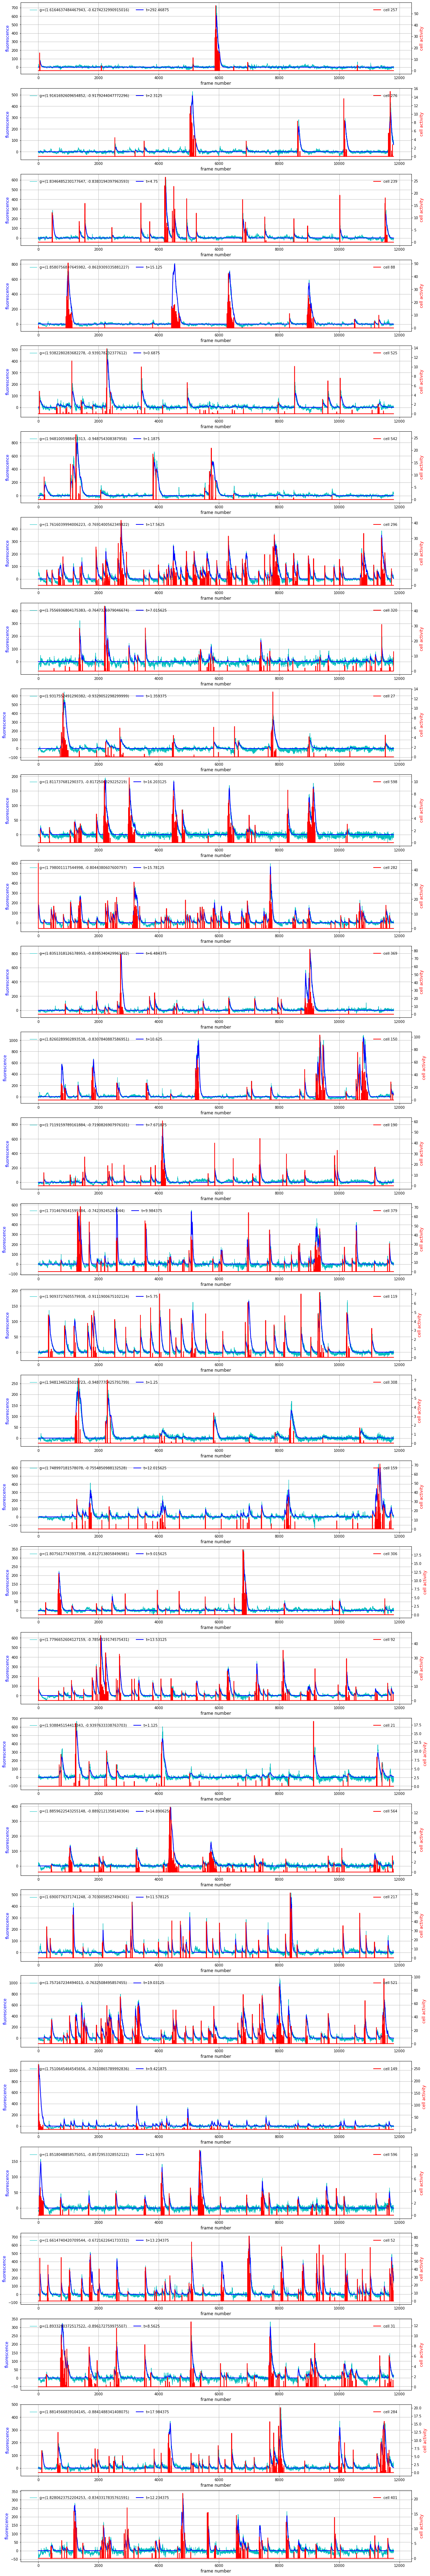

In [41]:
plt.figure(figsize=(20, sampleN*12))

sp = 0
for i in cells:
    plt.subplot(100, 1, sp+1)
    sp += 1
    ax  = plt.gca()
    ax2 = ax.twinx()
    #simpleaxis(ax)
    #simpleaxis(ax2)
    ax.plot(raw[i], lw=1, label='g='+str(g[i]), c='c')
    ax.plot(c[i], lw=2, label='t='+str(t[i]), c='b')
    ax2.plot(s[i], lw=2, label='cell '+str(i), c='r')
    ax.grid(True)
    ax2.legend(ncol=3, frameon=False, loc=(.9,.85));
    ax.legend(ncol=3, frameon=False, loc=(.02,.85));
#    plt.title("AR(1), L1: No g-Optimization", fontsize=15,color='black')
    ax.set_ylabel("fluorescence",fontsize=12,color='blue')
    ax2.set_ylabel("cell activity",fontsize=12,color='red')
    ax.set_xlabel('frame number', fontsize=12, color='black')

### 4.(c) Scatter plot for $g_1$ and $g_2$. Find the best fit and its function.

  * The best fit function slightly changes for every set of cells.
  * Thus the $g_1$ interval that satisfies all conditions changes for every set, as well.

the linear best fit function of the g's is g2 = -0.9637576572737818 * g1 + 0.9287018846819671
The determinant < 0 when g_1 is in: [1.9049820261163402, 1.9500486029787871]


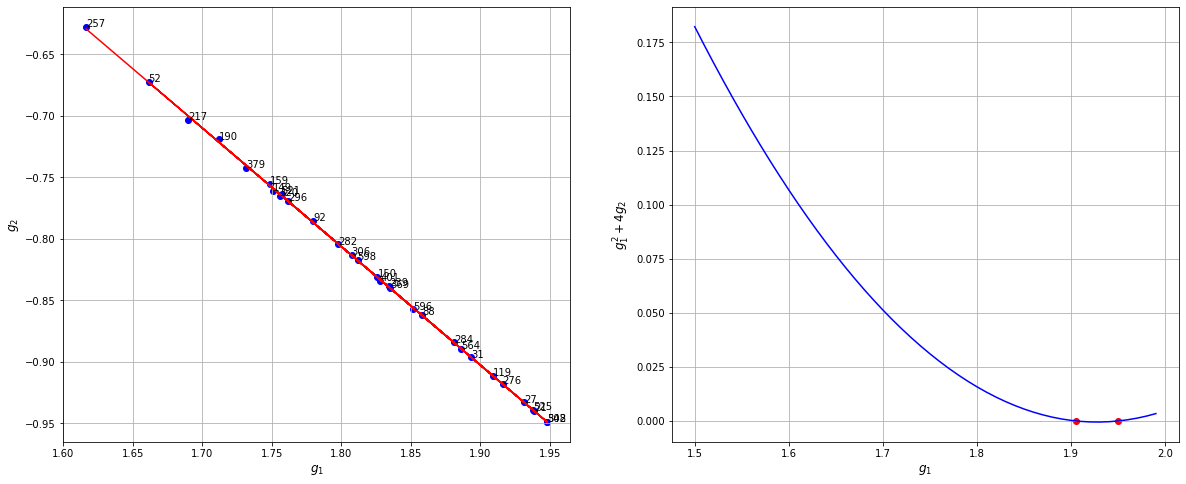

In [42]:
m, g2_int = np.polyfit(deconvolved_data['g1'], deconvolved_data['g2'], 1)
try:
    all_g1 = False
    g1_ints = [-2*m - 2*math.sqrt(pow(m, 2)-g2_int), -2*m + 2*math.sqrt(pow(m, 2)-g2_int)]
except:
    all_g1 = True
    err = "No g1 intercepts. Determinant is " + str(pow(m, 2) - g2_int)

plt.figure(figsize=(20, 8))

plt.subplot(121)
# Scatter plot of g1 vs g2
plt.scatter(deconvolved_data['g1'], deconvolved_data['g2'], c='b')
# Best fit of g1 vs g2
plt.plot(deconvolved_data['g1'], m * deconvolved_data['g1'] + g2_int, c='r')

for i, txt in enumerate(deconvolved_data['cell']):
    plt.annotate(txt, (deconvolved_data['g1'][txt],deconvolved_data['g2'][txt]))

plt.ylabel("$g_2$", fontsize=12, color='black')
plt.xlabel("$g_1$", fontsize=12, color='black')
plt.grid()

plt.subplot(122)
plt.plot(np.arange(1.5, 2, 0.01), pow(np.arange(1.5, 2, 0.01),2) + 4*(m * np.arange(1.5, 2, 0.01) + g2_int), c='b')
if all_g1 == False:
    plt.scatter(g1_ints, [0, 0], c='r')
plt.xlabel("$g_1$", fontsize=12, color='black')
plt.ylabel("$g_1^2+4g_2$", fontsize=12, color='black')
plt.grid()

print('the linear best fit function of the g\'s is g2 =', m,'* g1 +', g2_int)
if all_g1 == True:
    print(err)
if all_g1 == False:
    print("The determinant < 0 when g_1 is in:", g1_ints)

## 5. Manually Choose g.

There are two ways to go about this:
  1. Grab the g values that gave a pretty result in the list of deconvolution plots.
  2. Use the regression above to extract the $g_2$ from any $g_1$ value you want.
  
I personally prefer the second option, since very oftentimes none of the plots are very pretty. Furthermore, it's extremely likely that any off-handed tweaking of the g values will result in a dismal fit. One downside is, with some sets of cells, the regression ends up giving a constraint that blocks out a big chunk of $g_1$. (i.e. $g_1 \not\in [1.9, 2.3]$) When this happens, run from the sample cell set deconvolution step again, or simply resort to the first option.

Pick $g_1$ such that $0<g_1<2$. Refer to the deconvolution plots above to aim for whatever $g_1$ values that give the best general result.<br>
Then, we use the linear regression fit from above to calculate $g_2$.<br>
Finally, this cell reports whether the $g$ values will satisfy the algebraic steps in deconvolution, namely $g_1^2>-4g_2$. (Since $m$ and $b$ are calculated from $g_1$ via the above regression, the $g_1$ interval within which $g_1^2>-4g_2$ is satisfied is different for each test cell set.) Refer to the result in the previous cell when deciding which $g_1$ estimate to use.

**As I mentioned above, there seems to be another mathematical constraint in deconvolution that I haven't been able to take account of. The g values might not work even if this cell says it will. Sorry; work in progress.**

In [68]:
# 1. From cell optimization...
model_cell = 119 # Cell ID of the deconvolution trace you like from the plots above.
g_manual = list(deconvolved_data[['g1','g2']].loc[model_cell])
print('Using the g values from cell ' + str(model_cell) + '. The g values are:', g_manual)

Using the g values from cell 276. The g values are: [1.9161692609654852, -0.9179244047772296]


In [37]:
# 2. From regression...
g1_manual = 1.93
g2_manual = m * g1_manual + g2_int
g_manual = [g1_manual, g2_manual]

print('Manually chosen g values based on the linear regression is:', g_manual)
print('The deconvolution step will work:', pow(g_manual[0],2) + 4*g_manual[1] >= 0)

Manually chosen g values based on the linear regression is: [1.93, -0.9306174440583543]
The deconvolution step will work: True


## 6. Deconvolve All Cell Traces with the Chosen $[g_1, g_2]$

In [69]:
print('Using the g values:', g_manual)

c={}
s={}
b={}
g={}
lam={}
t={}

for i in range(len(raw)):
    # We're using... AR(2): G(None, None), 
    #                L1 Norm: penalty=1, 
    #                50 initial points for decay const: optimize_g, 
    #                3 optimization steps each: max_iter=3
    t1 = time.process_time()
    c[i], s[i], b[i], g[i], lam[i] = deconvolve(raw[i], g=g_manual)#, penalty=1, optimize_g=50, max_iter=3) 
    t2 = time.process_time()
    t[i] = t2 - t1
    print("cell", i, "processing time:", t[i])

cell 0 processing time: 0.34375
cell 1 processing time: 0.890625
cell 2 processing time: 0.96875
cell 3 processing time: 0.375
cell 4 processing time: 1.140625
cell 5 processing time: 0.3125
cell 6 processing time: 0.3125
cell 7 processing time: 0.1875
cell 8 processing time: 0.25
cell 9 processing time: 0.25
cell 10 processing time: 0.1875
cell 11 processing time: 0.296875
cell 12 processing time: 0.25
cell 13 processing time: 0.375
cell 14 processing time: 0.75
cell 15 processing time: 0.125
cell 16 processing time: 0.125
cell 17 processing time: 0.3125
cell 18 processing time: 0.375
cell 19 processing time: 0.28125
cell 20 processing time: 0.25
cell 21 processing time: 0.3125
cell 22 processing time: 0.375
cell 23 processing time: 0.5625
cell 24 processing time: 0.1875
cell 25 processing time: 0.375


C:\Users\raymo\Documents\GitHub\OASIS\oasis\functions.py:712: RuntimeWarning: invalid value encountered in double_scalars
  tmp[:l] = max(0, np.exp(log(d) * np.arange(l)).dot(y[:l]) * (1 - d * d)


cell 26 processing time: 0.3125
cell 27 processing time: 0.4375
cell 28 processing time: 0.625
cell 29 processing time: 0.25
cell 30 processing time: 0.1875
cell 31 processing time: 0.3125
cell 32 processing time: 0.625
cell 33 processing time: 0.1875
cell 34 processing time: 0.1875
cell 35 processing time: 0.25
cell 36 processing time: 0.1875
cell 37 processing time: 0.125
cell 38 processing time: 0.1875
cell 39 processing time: 0.375
cell 40 processing time: 0.25
cell 41 processing time: 0.25
cell 42 processing time: 0.1875
cell 43 processing time: 0.1875
cell 44 processing time: 0.0625
cell 45 processing time: 0.359375
cell 46 processing time: 0.25
cell 47 processing time: 0.1875
cell 48 processing time: 0.328125
cell 49 processing time: 0.4375
cell 50 processing time: 0.9375
cell 51 processing time: 0.3125
cell 52 processing time: 0.25
cell 53 processing time: 0.6875
cell 54 processing time: 0.296875
cell 55 processing time: 2.3125
cell 56 processing time: 0.4375
cell 57 processing

cell 282 processing time: 0.4375
cell 283 processing time: 0.5
cell 284 processing time: 0.375
cell 285 processing time: 0.1875
cell 286 processing time: 0.625
cell 287 processing time: 0.3125
cell 288 processing time: 0.375
cell 289 processing time: 1.8125
cell 290 processing time: 0.375
cell 291 processing time: 0.75
cell 292 processing time: 0.25
cell 293 processing time: 0.875
cell 294 processing time: 0.1875
cell 295 processing time: 0.6875
cell 296 processing time: 0.6875
cell 297 processing time: 0.765625
cell 298 processing time: 0.8125
cell 299 processing time: 0.5625
cell 300 processing time: 0.4375
cell 301 processing time: 0.625
cell 302 processing time: 0.25
cell 303 processing time: 0.4375
cell 304 processing time: 0.375
cell 305 processing time: 0.75
cell 306 processing time: 0.1875
cell 307 processing time: 0.4375
cell 308 processing time: 0.625
cell 309 processing time: 0.5
cell 310 processing time: 0.125
cell 311 processing time: 0.875
cell 312 processing time: 0.25
c

cell 537 processing time: 0.25
cell 538 processing time: 0.25
cell 539 processing time: 0.25
cell 540 processing time: 0.3125
cell 541 processing time: 0.25
cell 542 processing time: 0.4375
cell 543 processing time: 0.3125
cell 544 processing time: 0.3125
cell 545 processing time: 0.984375
cell 546 processing time: 0.4375
cell 547 processing time: 0.375
cell 548 processing time: 0.625
cell 549 processing time: 0.375
cell 550 processing time: 0.25
cell 551 processing time: 0.375
cell 552 processing time: 0.3125
cell 553 processing time: 1.3125
cell 554 processing time: 0.375
cell 555 processing time: 0.75
cell 556 processing time: 1.5
cell 557 processing time: 0.671875
cell 558 processing time: 0.5625
cell 559 processing time: 0.375
cell 560 processing time: 0.1875
cell 561 processing time: 1.25
cell 562 processing time: 0.25
cell 563 processing time: 0.3125
cell 564 processing time: 0.6875
cell 565 processing time: 0.1875
cell 566 processing time: 0.4375
cell 567 processing time: 0.187

### Plot the deconvolution traces of the first 100 cells

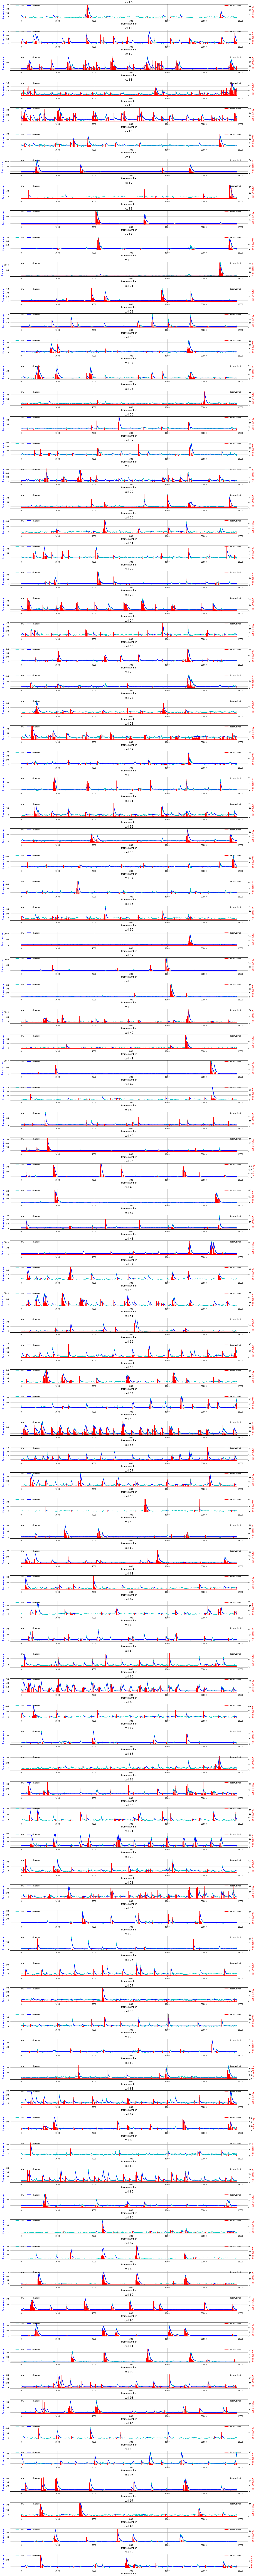

In [70]:
k=100

plt.figure(figsize=(20, k*2))
for i in range(k):
    plt.subplot(100, 1, i+1)
    plt.tight_layout()
    ax  = plt.gca()
    ax2 = ax.twinx()
    #simpleaxis(ax)
    #simpleaxis(ax2)
    ax.plot(raw[i], lw=1, label='raw', c='c')
    ax.plot(c[i], lw=2, label='denoised', c='b')
    ax2.plot(s[i], lw=2, label='deconvolved', c='r')
    ax.grid(True)
    ax2.legend(ncol=3, frameon=False, loc=(.9,.8))
    ax.legend(ncol=3, frameon=False, loc=(.02,.8))
    plt.title("cell " + str(i), fontsize=15, color='black')
    ax.set_ylabel("fluorescence", fontsize=12, color='blue')
    ax2.set_ylabel("cell activity",fontsize=12, color='red')
    ax.set_xlabel('frame number', fontsize=12, color='black')

## 7. Export Deconvolution Data for Further Analyses

In [71]:
fname = '../Data-Analysis/activity_traces_c276.obj'

raw_dict = {}
for n, i in enumerate(raw):
    raw_dict[n] = i

all_traces = pd.DataFrame(raw_dict.keys(), index=raw_dict.keys(), columns=['cell'])
all_traces['raw']=all_traces.cell.map(raw_dict)
all_traces['calcium']=all_traces.cell.map(c)
all_traces['spike']=all_traces.cell.map(s)
all_traces['g']=all_traces.cell.map(g)
all_traces['time']=all_traces.cell.map(t)
all_traces['background']=all_traces.cell.map(b)
all_traces['Lagrangian']=all_traces.cell.map(lam)

with open(fname, 'wb') as file:
    pickle.dump(all_traces, file)
    
all_traces

cell                                                raw  \
0       0  [134.12652523075627, 121.7440184758787, 114.85...   
1       1  [-5.1907601722064864, 12.242229555840812, 4.75...   
2       2  [7.059384416226946, 6.3511771097736744, 5.3923...   
3       3  [164.99183699387538, 140.86577746495686, 136.9...   
4       4  [56.674078322196934, 59.26837859095397, 53.103...   
..    ...                                                ...   
604   604  [22.738192501370655, 19.51965321115685, 20.495...   
605   605  [5.205545169295554, 28.372739652875158, 29.069...   
606   606  [73.14587385139538, 92.4865415405412, 93.70697...   
607   607  [-17.905314235356702, -11.752386600176774, -13...   
608   608  [-3.5015346063687405, -6.281623200227958, -10....   

                                               calcium  \
0    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.2491962...   
1    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.90330915...   
2    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.42938350...   
4    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
..                                                 ...   
604  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
605  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
606  [0.0, 0.0, 9.131337926247719, 17.4971890457641...   
607  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
608  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                 spike  \
0    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.2491962...   
1    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.90330915...   
2    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.42938350...   
4    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
..                                                 ...   
604  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
605  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
606  [0.0, 0.0, 9.131337926247719, 0.0, 0.0, 0.0, 0...   
607  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
608  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                             g      time  background  \
0    [1.9161692609654852, -0.9179244047772296]  0.343750    0.000000   
1    [1.9161692609654852, -0.9179244047772296]  0.890625    0.000000   
2    [1.9161692609654852, -0.9179244047772296]  0.968750    0.000000   
3    [1.9161692609654852, -0.9179244047772296]  0.375000    0.000000   
4    [1.9161692609654852, -0.9179244047772296]  1.140625    0.000000   
..                                         ...       ...         ...   
604  [1.9161692609654852, -0.9179244047772296]  0.828125    0.000000   
605  [1.9161692609654852, -0.9179244047772296]  0.625000    0.000000   
606  [1.9161692609654852, -0.9179244047772296]  0.625000    0.000000   
607  [1.9161692609654852, -0.9179244047772296]  0.312500    1.025552   
608  [1.9161692609654852, -0.9179244047772296]  0.250000    0.000000   

     Lagrangian  
0      0.000000  
1      0.000000  
2      0.000000  
3      0.000000  
4      0.000000  
..          ...  
604    0.000000  
605    0.000000  
606    0.000000  
607 -584.312461  
608    0.000000  

[609 rows x 8 columns]